In [1]:
import numpy as np
import pandas as pd
import scipy.io
import os
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [91]:

Ow=128
n_freq=11
n_pos=60
freq=[5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5,9.0,9.5,10.0]
end_depth=[256,282,308,334,360,384,410,436,462,488,512]
Oh=[156,172,188,204,220,234,250,266,282,298,312]

In [93]:
def b_mode(n,num_img):
    B_mode=[]              # Normalized images aquired from RF data 
    path1="/home/abhinav/Abhinav_multiFrequency_data/B_mode/"
    for i,folder in enumerate(sorted(os.listdir(path1))):
        if i in num_img:
            pass
        else:
            name=sorted(os.listdir(path1+folder))[n-1]
            data=cv2.imread(path1+folder+"/"+name)
            data=data[:,:,0]
            B_mode.append(data)
    return np.array(B_mode) 

In [94]:
def conf_map(n):
    Confidence_map=[]
    pathc="/home/abhinav/Abhinav_multiFrequency_data/MF_Confidence_map/"
    for folder in sorted(os.listdir(pathc)):
        name=sorted(os.listdir(pathc+folder))[n-1]
        data=scipy.io.loadmat(pathc+folder+"/"+name)
        data=data["map"]
        Confidence_map.append(data)
    Confidence_map=np.array(Confidence_map)
    confidence=np.reshape(Confidence_map,np.prod(Confidence_map.shape))
    return confidence


In [102]:
def lable():
    Lable=[]
    path_l= "/home/abhinav/Abhinav_multiFrequency_data/Grayscale_mask/"
    for name in sorted(os.listdir(path_l)):
        data=cv2.imread(path_l+name)
        data=data[:,:,0]
        Lable.append(data)
    Lable=np.array(Lable)
    Lable=np.reshape(Lable,np.prod(Lable.shape))
    return Lable

Variables used

In [100]:
def df_data(n):
    path="/home/abhinav/Abhinav_multiFrequency_data/RF_data/"
    rfdata=[]
    for folder in sorted(os.listdir(path)):                    ## directory for rf data
        name = sorted(os.listdir(path+folder))[n-1]           ## directory for b_mode images
        RFdata=scipy.io.loadmat(path+folder+"/"+name)
        if "ImageData" in RFdata:
            RFdata=RFdata["ImageData"]             ## after folder 07 there is ImageData befor there was ImgData
        else:
            RFdata=RFdata["ImgData"]               ## the data is stored in the form of dictionary where "ImgData" is of our
            RFdata=RFdata[0,0]                     ## interest (before 07 folder there was 3 channls)
        p=int(80*freq[n-1]/freq[0])
        q=int(end_depth[n-1]-(20*freq[n-1]/freq[0]))
        RFdata=cv2.resize(RFdata,(128,end_depth[n-1]),interpolation=cv2.INTER_NEAREST)   ## resizing data wrt 5Mhz freq data
        RFdata=RFdata[p:q,:]                   # 256 samples
        rfdata.append(RFdata)
    rfdata=np.array(rfdata)
    return rfdata

In [97]:
def column_naming():
    name_columns=[]
    c=1
    for i in range(56):
        if i%2==0:
            name_columns.append(f"m{c}")
        else:
            name_columns.append(f"\u03A9{c}")                   # \u03A9 = Ω
            c+=1
    return name_columns

In [103]:
def create_dataframe(n):
    si=(Oh[n-1])*Ow
    rfdata=df_data(n)
    N=np.zeros((si*n_pos,56))
    for p,RFdata in enumerate(rfdata):
        q=0
        x2=np.multiply(RFdata,RFdata)
        x4=np.multiply(x2,x2)
        for k in range(3,31):
            kernel=np.ones((k,3))*(1/(k*3))
            omega=ndimage.convolve(x2,kernel,mode="constant",cval=0)
            
            nume = np.multiply(omega,omega)
            deno = ndimage.convolve(x4,kernel,mode='constant',cval=0) - nume
            # deno[deno==0]=1.0
            m=np.divide(nume,deno)
            
            N[p*si:p*si+si,q],N[p*si:p*si+si,q+1]=m.flatten(),omega.flatten()
            q+=2
    df=pd.DataFrame(N)
    df.columns=column_naming()
    df['c']=conf_map(n)
    df['label']=lable()
    
    return df

In [104]:
df1=create_dataframe(1)

In [63]:
df1=create_dataframe(1)
df2=create_dataframe(2)
df3=create_dataframe(3)
df4=create_dataframe(4)
df5=create_dataframe(5)
df6=create_dataframe(6)
df7=create_dataframe(7)
df8=create_dataframe(8)
df9=create_dataframe(9)
df10=create_dataframe(10)
d11=create_dataframe(11)

In [105]:
from sklearn import tree
def Node_count(classifier):      # calculating number of nodes and depth per tree in forest
    node=[]                    
    depth=[]
    for i in range(len(classifier.estimators_)):  # classifier.estimators_= n_estimators =50
        N=classifier.estimators_[i].tree_.node_count
        D=classifier.estimators_[i].tree_.max_depth
        node.append(N)
        depth.append(D)
    return node,depth

In [106]:
def recall(yts,ypr):
    R0,R1,R2=0,0,0
    c0,c1,c2=0,0,0
    yts=list(yts)
    for index in range(len(yts)):
        if yts[index]==0:
            R0+=1
            if ypr[index]==0:
                c0+=1
        elif yts[index]==127:
            R1+=1
            if ypr[index]==127:
                c1+=1
        elif yts[index]==255:
            R2+=1
            if ypr[index]==255:
                c2+=1
    print(f"Recall_val w.r.t background  : {(c0/R0)*100:.2f} %")
    print(f"Recall_val w.r.t hypoechoic  : {(c1/R1)*100:.2f} %")
    print(f"Recall_val w.r.t hyperechoic : {(c2/R2)*100:.2f} %")
    return

In [107]:
def train_test(df):
    np.random.seed(10)
    img_num=np.random.randint(low=0, high=n_pos, size=6)
    Dctr=pd.DataFrame()
    for n in img_num:
        Dctr=pd.concat([Dctr,df.iloc[(n-1)*si:n*si]])
    Dcts=df.drop(Dctr.index)
    xtsc,ytsc=Dcts.iloc[:,:-1],Dcts.iloc[:,-1]
    xtrc,ytrc=Dctr.iloc[:,:-1],Dctr.iloc[:,-1]
    modelc=RandomForestClassifier(n_estimators=50, criterion='gini',
                                max_depth=None, min_samples_leaf=50, max_features='sqrt', verbose=1, n_jobs=-1)
    modelc.fit(xtrc,ytrc)                  # training
    # Nc,Dc=Node_count(modelc)
    ypsc=modelc.predict(xtsc)
    print(f"accuracy_score : {(accuracy_score(ytsc,ypsc) * 100):.2f}")
    recall(ytsc,ypsc)
    return img_num,ytsc,ypsc

In [108]:
def visualize(n,num_img,yts,ypr,B_mode,si):
    Img=[]
    true_lable=[]
    pred_lable=[]
    for i in range(n_pos):
        x=60*(n-1)+i
        if i in num_img:
            continue
        Img.append(B_mode[x])
            
    for i in range(len(yts)//si):
        true_lable.append(np.reshape(list(yts[i*si:si+i*si]),(156,Ow)))
        pred_lable.append(np.reshape(ypr[i*si:si+i*si],(156,Ow)))
    
    plt.figure(figsize=(20,20))
    for i in range(len(num_img)):
        plt.subplot(1,len(num_img),i+1)
        plt.imshow(Img[i],cmap='gray')
        plt.axis("off")

    plt.figure(figsize=(20,20))
    for i in range(len(num_img)):
        plt.subplot(1,len(num_img),i+1)
        plt.imshow(true_lable[i],cmap='gray')
        plt.axis("off")

    plt.figure(figsize=(20,20))
    for i in range(len(num_img)):
        plt.subplot(1,len(num_img),i+1)
        plt.imshow(pred_lable[i],cmap='gray')
        plt.axis("off")

    return 


In [109]:
n1,yts1,ypr1=train_test(df1)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  50 | elapsed:    1.1s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.8s finished
[Parallel(n_jobs=48)]: Using backend ThreadingBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   6 out of  50 | elapsed:    0.3s remaining:    2.4s
[Parallel(n_jobs=48)]: Done  50 out of  50 | elapsed:    0.6s finished


accuracy_score : 92.81
Recall_val w.r.t background  : 98.51 %
Recall_val w.r.t hypoechoic  : 51.68 %
Recall_val w.r.t hyperechoic : 73.42 %


In [110]:
n1

array([ 9, 36, 15,  0, 49, 59])

In [111]:
len(yts1)/si

55.0

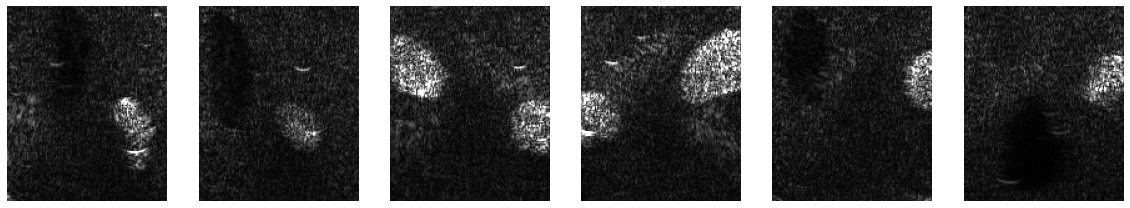

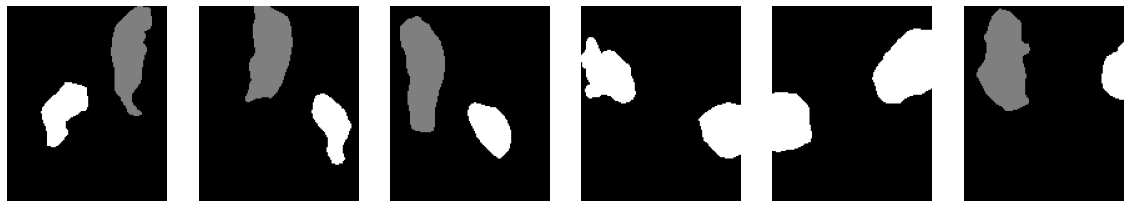

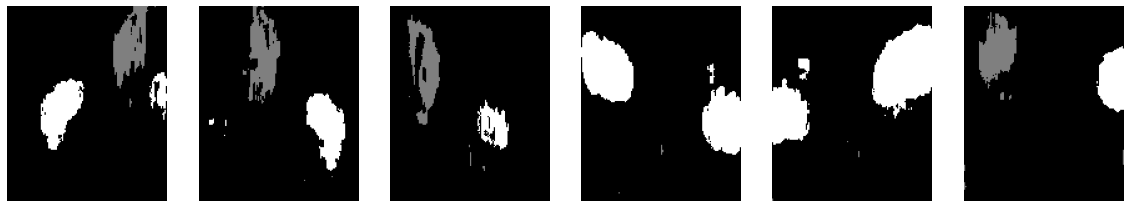

In [112]:
visualize(1,n1,yts1,ypr1,B_mode,si)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  50 | elapsed:    1.3s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.1s finished
[Parallel(n_jobs=48)]: Using backend ThreadingBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   6 out of  50 | elapsed:    0.3s remaining:    2.4s
[Parallel(n_jobs=48)]: Done  50 out of  50 | elapsed:    0.6s finished


accuracy_score : 93.39
Recall_val w.r.t background  : 98.90 %
Recall_val w.r.t hypoechoic  : 53.24 %
Recall_val w.r.t hyperechoic : 77.06 %


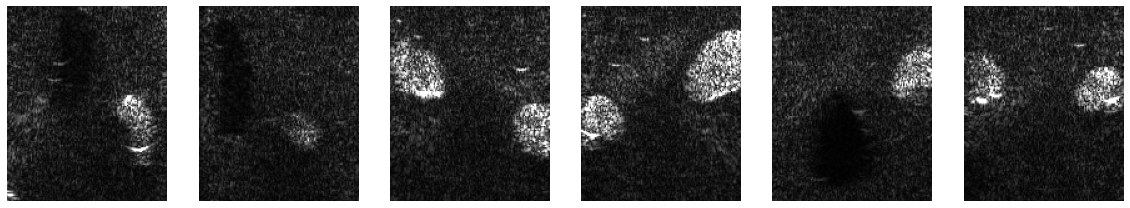

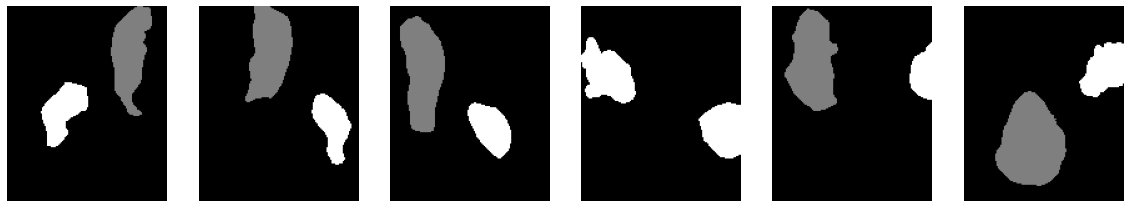

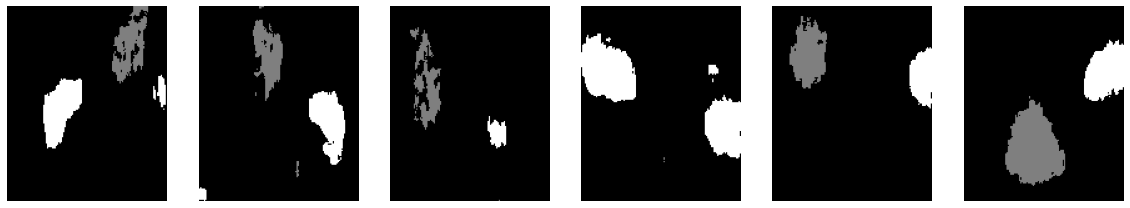

In [145]:
n2,yts2,ypr2=train_test(df2)
visualize(2,n2,yts2,ypr2,B_mode,si)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  50 | elapsed:    1.2s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.0s finished
[Parallel(n_jobs=48)]: Using backend ThreadingBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   6 out of  50 | elapsed:    0.3s remaining:    2.4s
[Parallel(n_jobs=48)]: Done  50 out of  50 | elapsed:    0.6s finished


accuracy_score : 94.60
Recall_val w.r.t background  : 98.91 %
Recall_val w.r.t hypoechoic  : 67.45 %
Recall_val w.r.t hyperechoic : 75.71 %


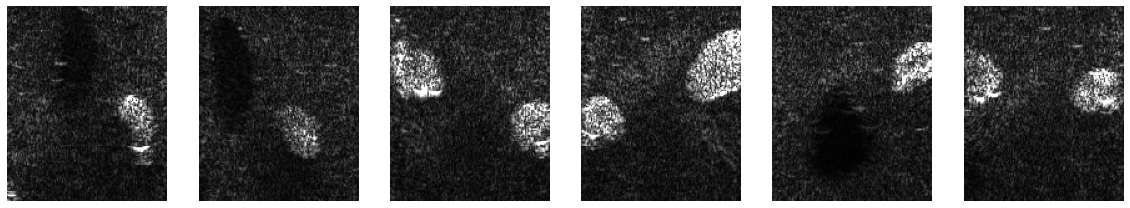

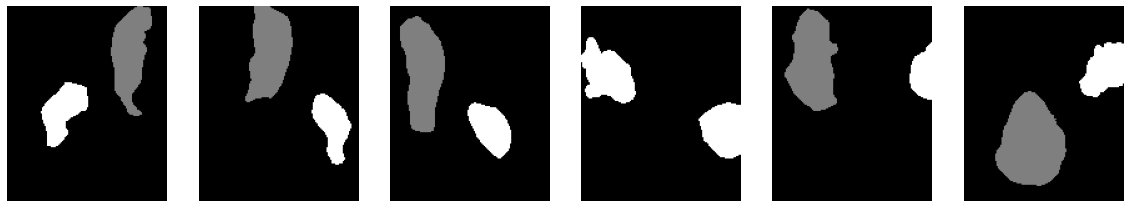

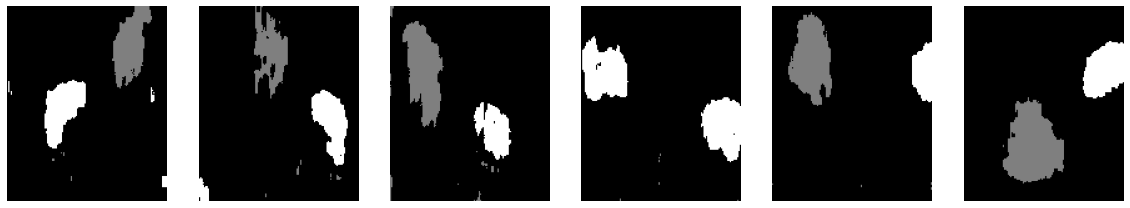

In [146]:
n3,yts3,ypr3=train_test(df4)
visualize(3,n3,yts3,ypr3,B_mode,si)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  50 | elapsed:    1.3s remaining:    9.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.1s finished
[Parallel(n_jobs=48)]: Using backend ThreadingBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   6 out of  50 | elapsed:    0.5s remaining:    3.6s
[Parallel(n_jobs=48)]: Done  50 out of  50 | elapsed:    0.7s finished


accuracy_score : 94.60
Recall_val w.r.t background  : 98.91 %
Recall_val w.r.t hypoechoic  : 67.45 %
Recall_val w.r.t hyperechoic : 75.71 %


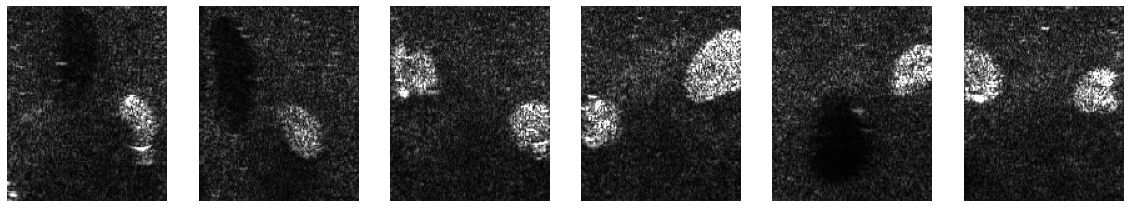

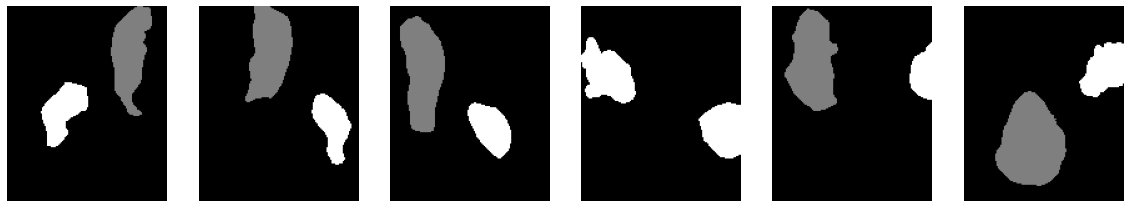

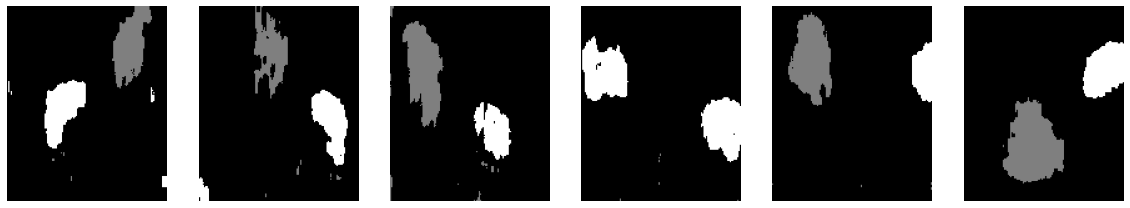

In [147]:
n4,yts4,ypr4=train_test(df4)
visualize(4,n4,yts4,ypr4,B_mode,si)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  50 | elapsed:    1.4s remaining:   10.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.3s finished
[Parallel(n_jobs=48)]: Using backend ThreadingBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   6 out of  50 | elapsed:    0.4s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  50 out of  50 | elapsed:    0.6s finished


accuracy_score : 94.91
Recall_val w.r.t background  : 98.61 %
Recall_val w.r.t hypoechoic  : 73.81 %
Recall_val w.r.t hyperechoic : 75.59 %


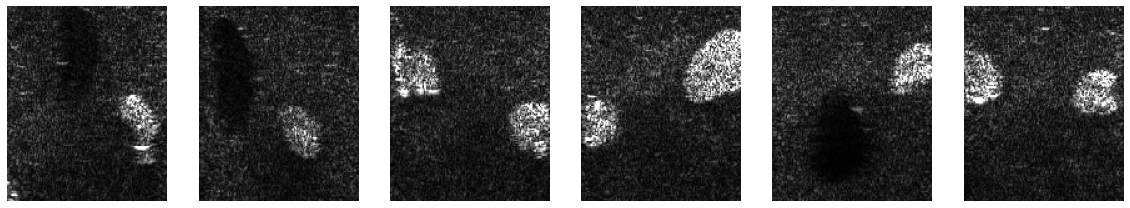

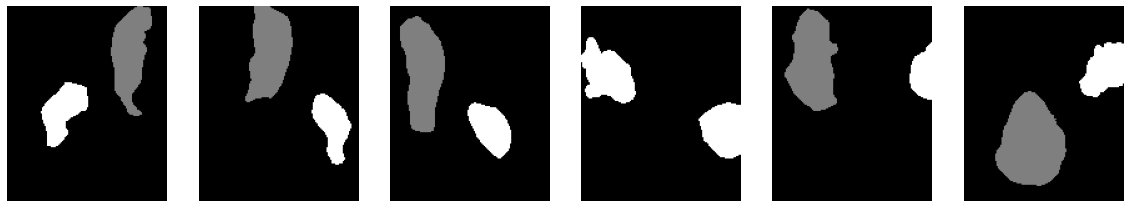

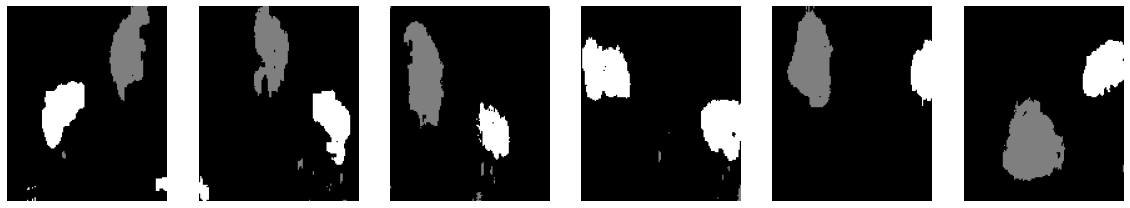

In [148]:
n5,yts5,ypr5=train_test(df5)
visualize(5,n5,yts5,ypr5,B_mode,si)

In [93]:
train_test(df6)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  50 | elapsed:    1.3s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.1s finished
[Parallel(n_jobs=48)]: Using backend ThreadingBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   6 out of  50 | elapsed:    0.6s remaining:    4.5s
[Parallel(n_jobs=48)]: Done  50 out of  50 | elapsed:    0.9s finished


accuracy_score : 94.75
Recall_val w.r.t background  : 98.62 %
Recall_val w.r.t hypoechoic  : 70.92 %
Recall_val w.r.t hyperechoic : 77.00 %


In [94]:
train_test(df7)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  50 | elapsed:    1.3s remaining:    9.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.0s finished
[Parallel(n_jobs=48)]: Using backend ThreadingBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   6 out of  50 | elapsed:    0.4s remaining:    2.6s
[Parallel(n_jobs=48)]: Done  50 out of  50 | elapsed:    0.6s finished


accuracy_score : 94.73
Recall_val w.r.t background  : 98.60 %
Recall_val w.r.t hypoechoic  : 71.31 %
Recall_val w.r.t hyperechoic : 76.39 %


In [95]:
train_test(df8)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  50 | elapsed:    1.3s remaining:    9.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.0s finished
[Parallel(n_jobs=48)]: Using backend ThreadingBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   6 out of  50 | elapsed:    0.4s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  50 out of  50 | elapsed:    0.7s finished


accuracy_score : 94.40
Recall_val w.r.t background  : 98.72 %
Recall_val w.r.t hypoechoic  : 67.19 %
Recall_val w.r.t hyperechoic : 75.41 %


In [96]:
train_test(df9)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  50 | elapsed:    1.3s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.1s finished
[Parallel(n_jobs=48)]: Using backend ThreadingBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   6 out of  50 | elapsed:    0.4s remaining:    2.9s
[Parallel(n_jobs=48)]: Done  50 out of  50 | elapsed:    0.7s finished


accuracy_score : 93.75
Recall_val w.r.t background  : 98.89 %
Recall_val w.r.t hypoechoic  : 60.08 %
Recall_val w.r.t hyperechoic : 73.08 %


In [97]:
train_test(df10)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  50 | elapsed:    1.3s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.0s finished
[Parallel(n_jobs=48)]: Using backend ThreadingBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   6 out of  50 | elapsed:    0.3s remaining:    2.2s
[Parallel(n_jobs=48)]: Done  50 out of  50 | elapsed:    0.6s finished


accuracy_score : 93.99
Recall_val w.r.t background  : 98.86 %
Recall_val w.r.t hypoechoic  : 63.30 %
Recall_val w.r.t hyperechoic : 72.58 %


In [100]:
train_test(df11)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  50 | elapsed:    1.3s remaining:    9.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.0s finished
[Parallel(n_jobs=48)]: Using backend ThreadingBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   6 out of  50 | elapsed:    0.4s remaining:    2.7s
[Parallel(n_jobs=48)]: Done  50 out of  50 | elapsed:    0.6s finished


accuracy_score : 92.32
Recall_val w.r.t background  : 98.91 %
Recall_val w.r.t hypoechoic  : 44.75 %
Recall_val w.r.t hyperechoic : 71.97 %


In [136]:
x=[1,2,3]
for i in range(6):
    if i in x:
        continue
    print(i)

0
4
5


In [46]:
A=np.array([[1,2,3],[4,5,6],[7,8,9]])
B=np.array([[1,2,3],[4,5,6],[7,8,9]])

In [48]:
(A==B).sum()

9